Successfully loaded game.csv.

Total games loaded for 2019 calendar year: 1269
Games remaining after cleaning NaNs: 1269

--- 2. TOP 10 REGULAR SEASON WINNING TEAMS (2019) ---
| Team   |   Regular_Season_Wins |
|:-------|----------------------:|
| MIL    |                    65 |
| HOU    |                    55 |
| DEN    |                    54 |
| TOR    |                    54 |
| UTA    |                    53 |
| BOS    |                    51 |
| PHI    |                    51 |
| LAC    |                    51 |
| MIA    |                    46 |
| POR    |                    46 |

--- 3. PREDICTED PLAYOFF TEAMS (Top 8 based on Regular Season Wins) ---
['MIL', 'HOU', 'DEN', 'TOR', 'UTA', 'BOS', 'PHI', 'LAC']

--- 4a. CLASSIFICATION REPORT (Home Win Prediction) ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       136
           1       0.82      0.90      0.86       182

    accuracy                           0.83       318

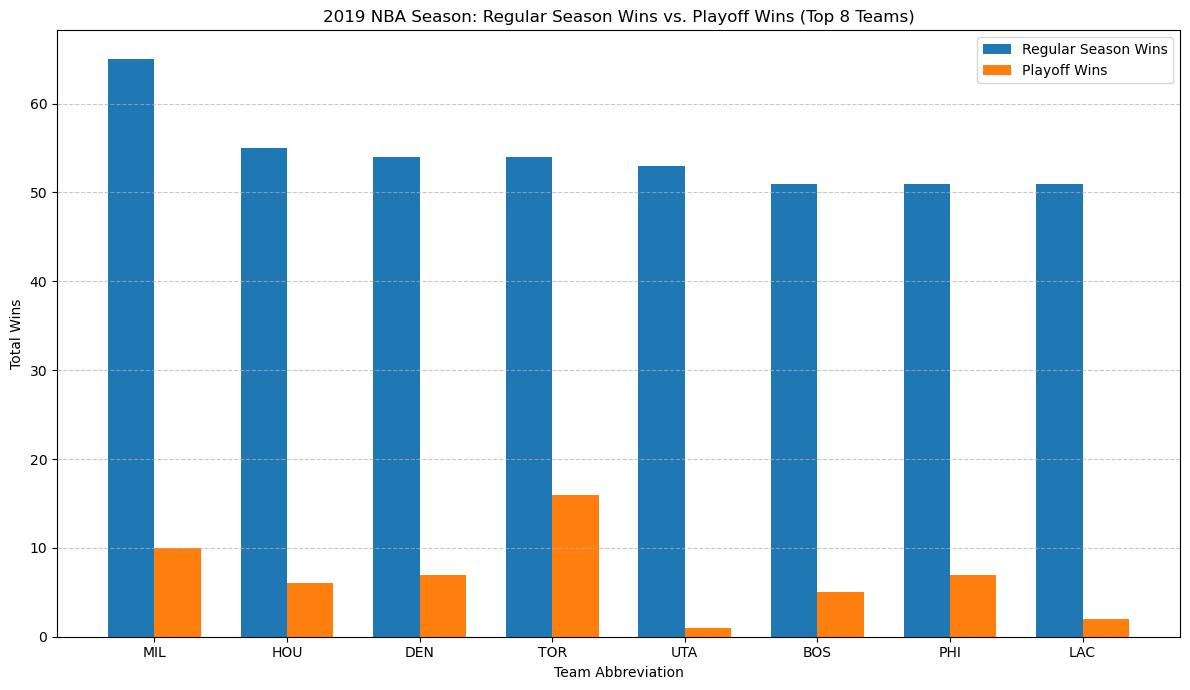

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import defaultdict
import random
import sys

# --- 1. Data Loading and Cleaning ---

try:
    df = pd.read_csv('/Users/danabalbuena/Downloads/archive (2)/csv/game.csv')
    print("Successfully loaded game.csv.")
except FileNotFoundError:
    # If running in a local environment, adjust the path if necessary.
    print("Error: The 'game.csv' file was not found. Please ensure it is correctly uploaded or the path is correct.")
    sys.exit(1)

# Filter data for the 2019 calendar year
df['game_date'] = pd.to_datetime(df['game_date'])
df_2019 = df[(df['game_date'].dt.year == 2019)].copy()

print(f"\nTotal games loaded for 2019 calendar year: {len(df_2019)}")

# Define columns needed for modeling
predictor_cols = [
    'fg_pct_home', 'fg3_pct_home', 'ft_pct_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
    'fg_pct_away', 'fg3_pct_away', 'ft_pct_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away'
]

# Drop rows with any missing values in critical columns
required_cols = predictor_cols + ['wl_home', 'wl_away', 'team_abbreviation_home', 'team_abbreviation_away', 'season_type']
df_2019.dropna(subset=required_cols, inplace=True)
print(f"Games remaining after cleaning NaNs: {len(df_2019)}")

# --- 2. Regular Season Team Ranking (Top 10) ---

def rank_regular_season_teams(data_frame):
    """Calculates total wins for each team in the regular season subset."""
    reg_season_df = data_frame[data_frame['season_type'] == 'Regular Season']
    wins = defaultdict(int)

    for _, row in reg_season_df.iterrows():
        # Tally wins for both home and away teams
        if row['wl_home'] == 'W':
            wins[row['team_abbreviation_home']] += 1
        if row['wl_away'] == 'W':
            wins[row['team_abbreviation_away']] += 1

    ranking_df = pd.DataFrame(wins.items(), columns=['Team', 'Regular_Season_Wins'])
    return ranking_df.sort_values(by='Regular_Season_Wins', ascending=False).reset_index(drop=True)

regular_season_ranking = rank_regular_season_teams(df_2019)
top_10_teams = regular_season_ranking.head(10)

print("\n--- 2. TOP 10 REGULAR SEASON WINNING TEAMS (2019) ---")
print(top_10_teams.to_markdown(index=False))

# --- 3. Predict 2019 Playoff Teams ---

# Prediction: Top 8 teams based on Regular Season Wins
N_PLAYOFF_TEAMS = 8
predicted_playoff_teams = regular_season_ranking.head(N_PLAYOFF_TEAMS)['Team'].tolist()

print(f"\n--- 3. PREDICTED PLAYOFF TEAMS (Top {N_PLAYOFF_TEAMS} based on Regular Season Wins) ---")
print(predicted_playoff_teams)

# --- 4. Supervised Classification Model: Home Win Prediction ---

# Target Feature: wl_home -> 1 (Win) or 0 (Loss)
df_2019['wl_home_numeric'] = df_2019['wl_home'].apply(lambda x: 1 if x == 'W' else 0)

# Feature Engineering: Differential features (Home Stat - Away Stat)
X = pd.DataFrame({
    'FG_PCT_DIFF': df_2019['fg_pct_home'] - df_2019['fg_pct_away'],
    'FG3_PCT_DIFF': df_2019['fg3_pct_home'] - df_2019['fg3_pct_away'],
    'FT_PCT_DIFF': df_2019['ft_pct_home'] - df_2019['ft_pct_away'],
    'REB_DIFF': df_2019['reb_home'] - df_2019['reb_away'],
    'AST_DIFF': df_2019['ast_home'] - df_2019['ast_away'],
    'STL_DIFF': df_2019['stl_home'] - df_2019['stl_away'],
    'BLK_DIFF': df_2019['blk_home'] - df_2019['blk_away'],
    'TOV_DIFF': df_2019['tov_home'] - df_2019['tov_away'], # Note: Negative TOV_DIFF is good for the home team
})

y = df_2019['wl_home_numeric']

# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] # Probability of a home win

print("\n--- 4a. CLASSIFICATION REPORT (Home Win Prediction) ---")
print(classification_report(y_test, y_pred))

# --- 5. Feature Importance Ranking (Strongest Predictors) ---

feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- 5. MOST IMPORTANT FEATURE RANKING (Strongest Predictors of Home Win) ---")
print(feature_importance.head(5).to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

# --- 6. Identifying and Analyzing 5 Incorrect Samples ---

# Combine test data and predictions for finding errors
results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred
results_df['Prob_Win'] = y_proba
results_df['Game_Index'] = results_df.index

# Filter for incorrect predictions (Actual != Predicted)
incorrect_samples = results_df[results_df['Actual'] != results_df['Predicted']]

# Get original game context for the incorrect samples
incorrect_samples_context = df_2019.loc[incorrect_samples['Game_Index']].copy()
incorrect_samples_context = incorrect_samples_context[['game_date', 'team_abbreviation_home', 'team_abbreviation_away', 'wl_home']].reset_index()

# Merge in the prediction details
incorrect_samples_context = incorrect_samples_context.merge(
    incorrect_samples[['Actual', 'Predicted', 'Prob_Win']],
    left_on='index', right_index=True, how='left'
)

# Randomly select up to 5 unique incorrect samples
wrong_samples_5 = incorrect_samples_context.sample(min(5, len(incorrect_samples_context)), random_state=1)

print("\n--- 6. FIVE INCORRECTLY PREDICTED SAMPLES FOR DISCUSSION ---")
print(wrong_samples_5[['game_date', 'team_abbreviation_home', 'team_abbreviation_away', 'wl_home', 'Prob_Win']].to_markdown(index=False))

# --- 7. Final Graph: Regular Season Wins vs. Playoff Winning Games ---

# Calculate actual playoff wins
playoffs_df = df_2019[df_2019['season_type'] == 'Playoffs']
playoff_wins = defaultdict(int)

for _, row in playoffs_df.iterrows():
    if row['wl_home'] == 'W':
        playoff_wins[row['team_abbreviation_home']] += 1
    if row['wl_away'] == 'W':
        playoff_wins[row['team_abbreviation_away']] += 1

playoff_wins_df = pd.DataFrame(playoff_wins.items(), columns=['Team', 'Playoff_Wins'])

# Merge with Regular Season Wins for comparison
comparison_df = top_10_teams.merge(playoff_wins_df, on='Team', how='left').fillna(0)
comparison_df['Playoff_Wins'] = comparison_df['Playoff_Wins'].astype(int)

# Filter for the predicted playoff teams (Top 8)
comparison_df_plot = comparison_df[comparison_df['Team'].isin(predicted_playoff_teams)].copy()

print("\n--- 7a. REGULAR SEASON VS. PLAYOFF WINS TABLE ---")
print(comparison_df_plot[['Team', 'Regular_Season_Wins', 'Playoff_Wins']].to_markdown(index=False))

# Plotting the comparison
plt.figure(figsize=(12, 7))
x = np.arange(len(comparison_df_plot['Team']))
width = 0.35

plt.bar(x - width/2, comparison_df_plot['Regular_Season_Wins'], width, label='Regular Season Wins', color='#1f77b4')
plt.bar(x + width/2, comparison_df_plot['Playoff_Wins'], width, label='Playoff Wins', color='#ff7f0e')

plt.ylabel('Total Wins')
plt.xlabel('Team Abbreviation')
plt.title('2019 NBA Season: Regular Season Wins vs. Playoff Wins (Top 8 Teams)')
plt.xticks(x, comparison_df_plot['Team'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()